# KMeans

In [1]:
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
# 样本平均轮廓系数
from sklearn.metrics import silhouette_score
# 所有样本的轮廓系数
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
import matplotlib as mpl
from sklearn.neighbors import KNeighborsClassifier
plt.rcParams['font.sans-serif']='SimHei'
plt.rcParams['axes.unicode_minus']=False
import warnings
warnings.filterwarnings('ignore')

## 加载数据集

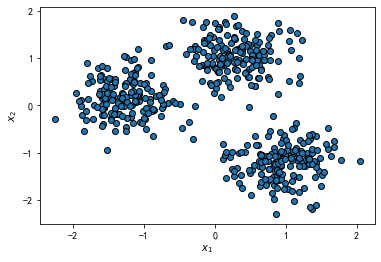

In [2]:
# 从3个正态分布的聚类中随机选择500个点生成一个数据集，然后对其进行归一化，以确保特征具有相同的尺度
X, Y = make_blobs(n_samples=500, centers=3, cluster_std=0.6, random_state=0)
X = StandardScaler().fit_transform(X)
def plot_data(X):
    plt.scatter(X[:, 0], X[:, 1], edgecolor='k')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()
plot_data(X)

## 聚类结果

In [3]:
labels_k2 = KMeans(n_clusters=2, random_state=0).fit_predict(X)
labels_k3 = KMeans(n_clusters=3, random_state=0).fit_predict(X)
labels_k4 = KMeans(n_clusters=4, random_state=0).fit_predict(X)
print(f'SI(2 clusters): {silhouette_score(X, labels_k2):.3f}')
print(f'SI(3 clusters): {silhouette_score(X, labels_k3):.3f}')
print(f'SI(4 clusters): {silhouette_score(X, labels_k4):.3f}')

SI(2 clusters): 0.569
SI(3 clusters): 0.659
SI(4 clusters): 0.539


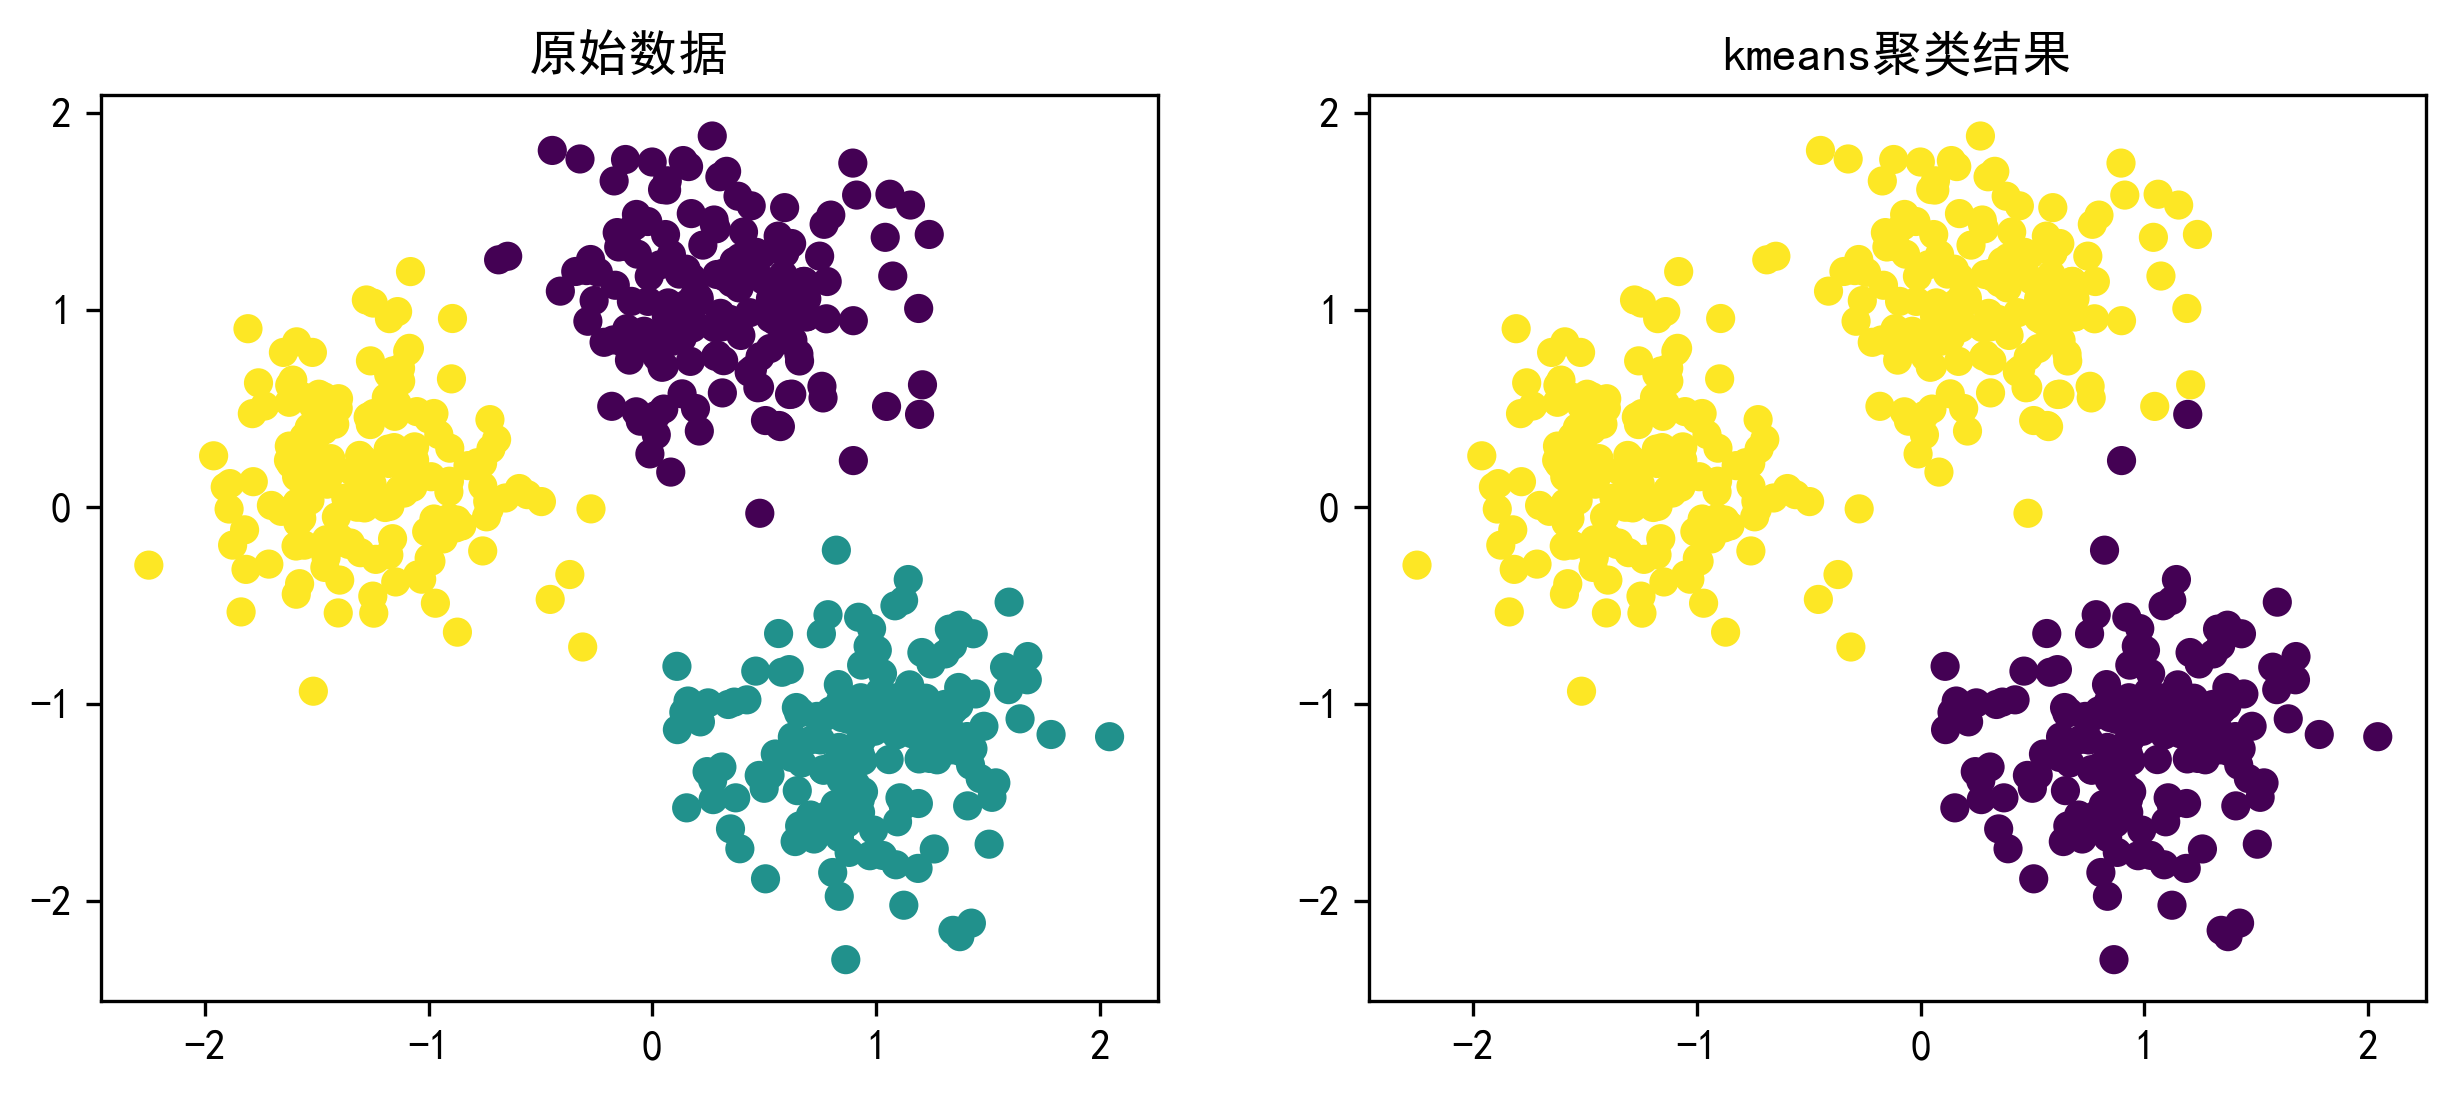

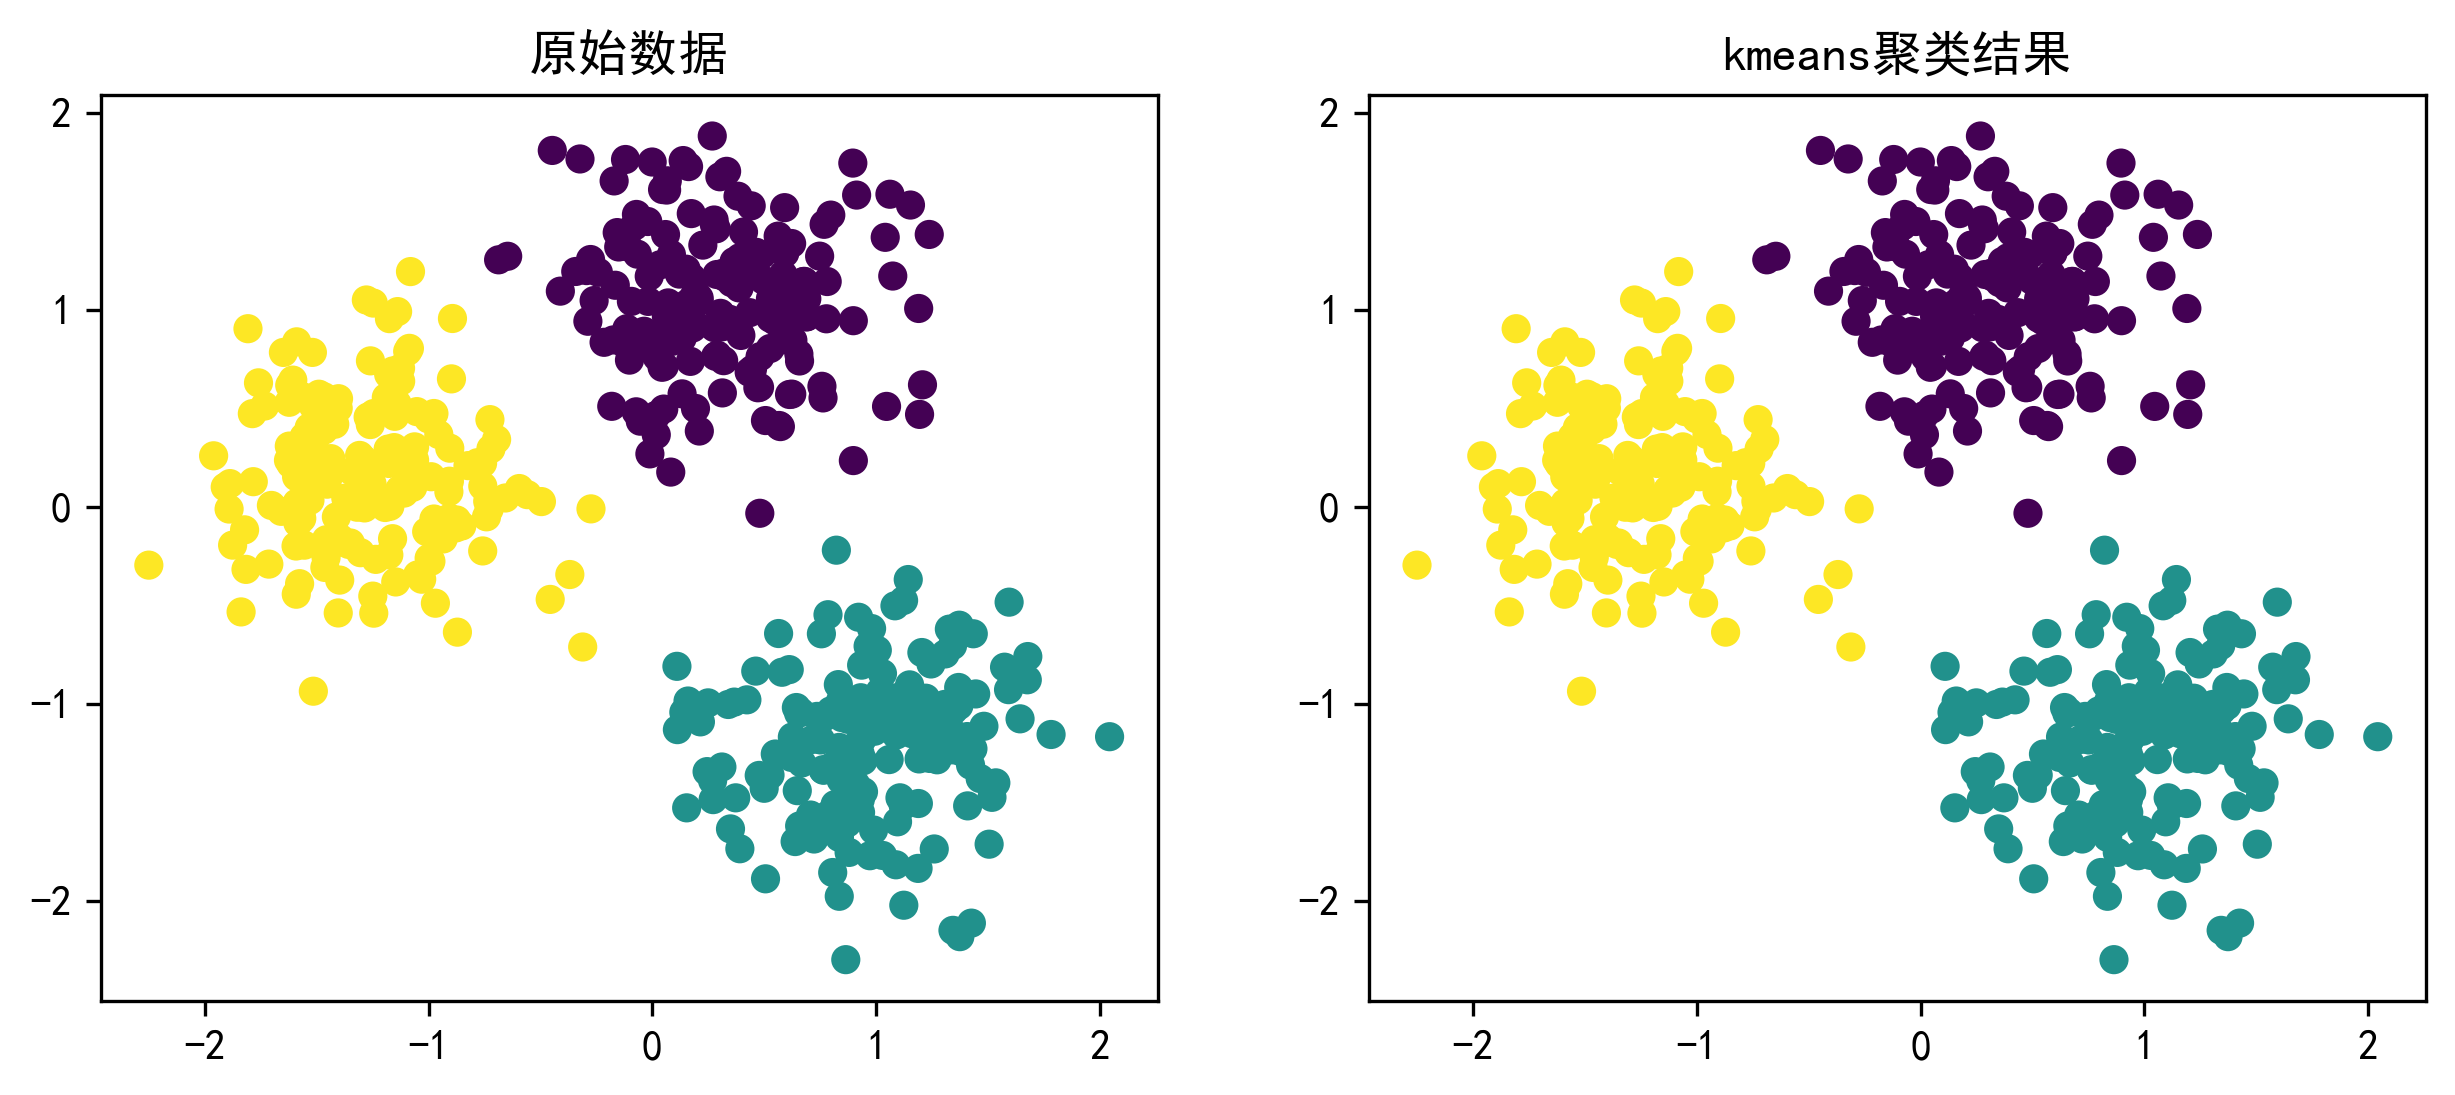

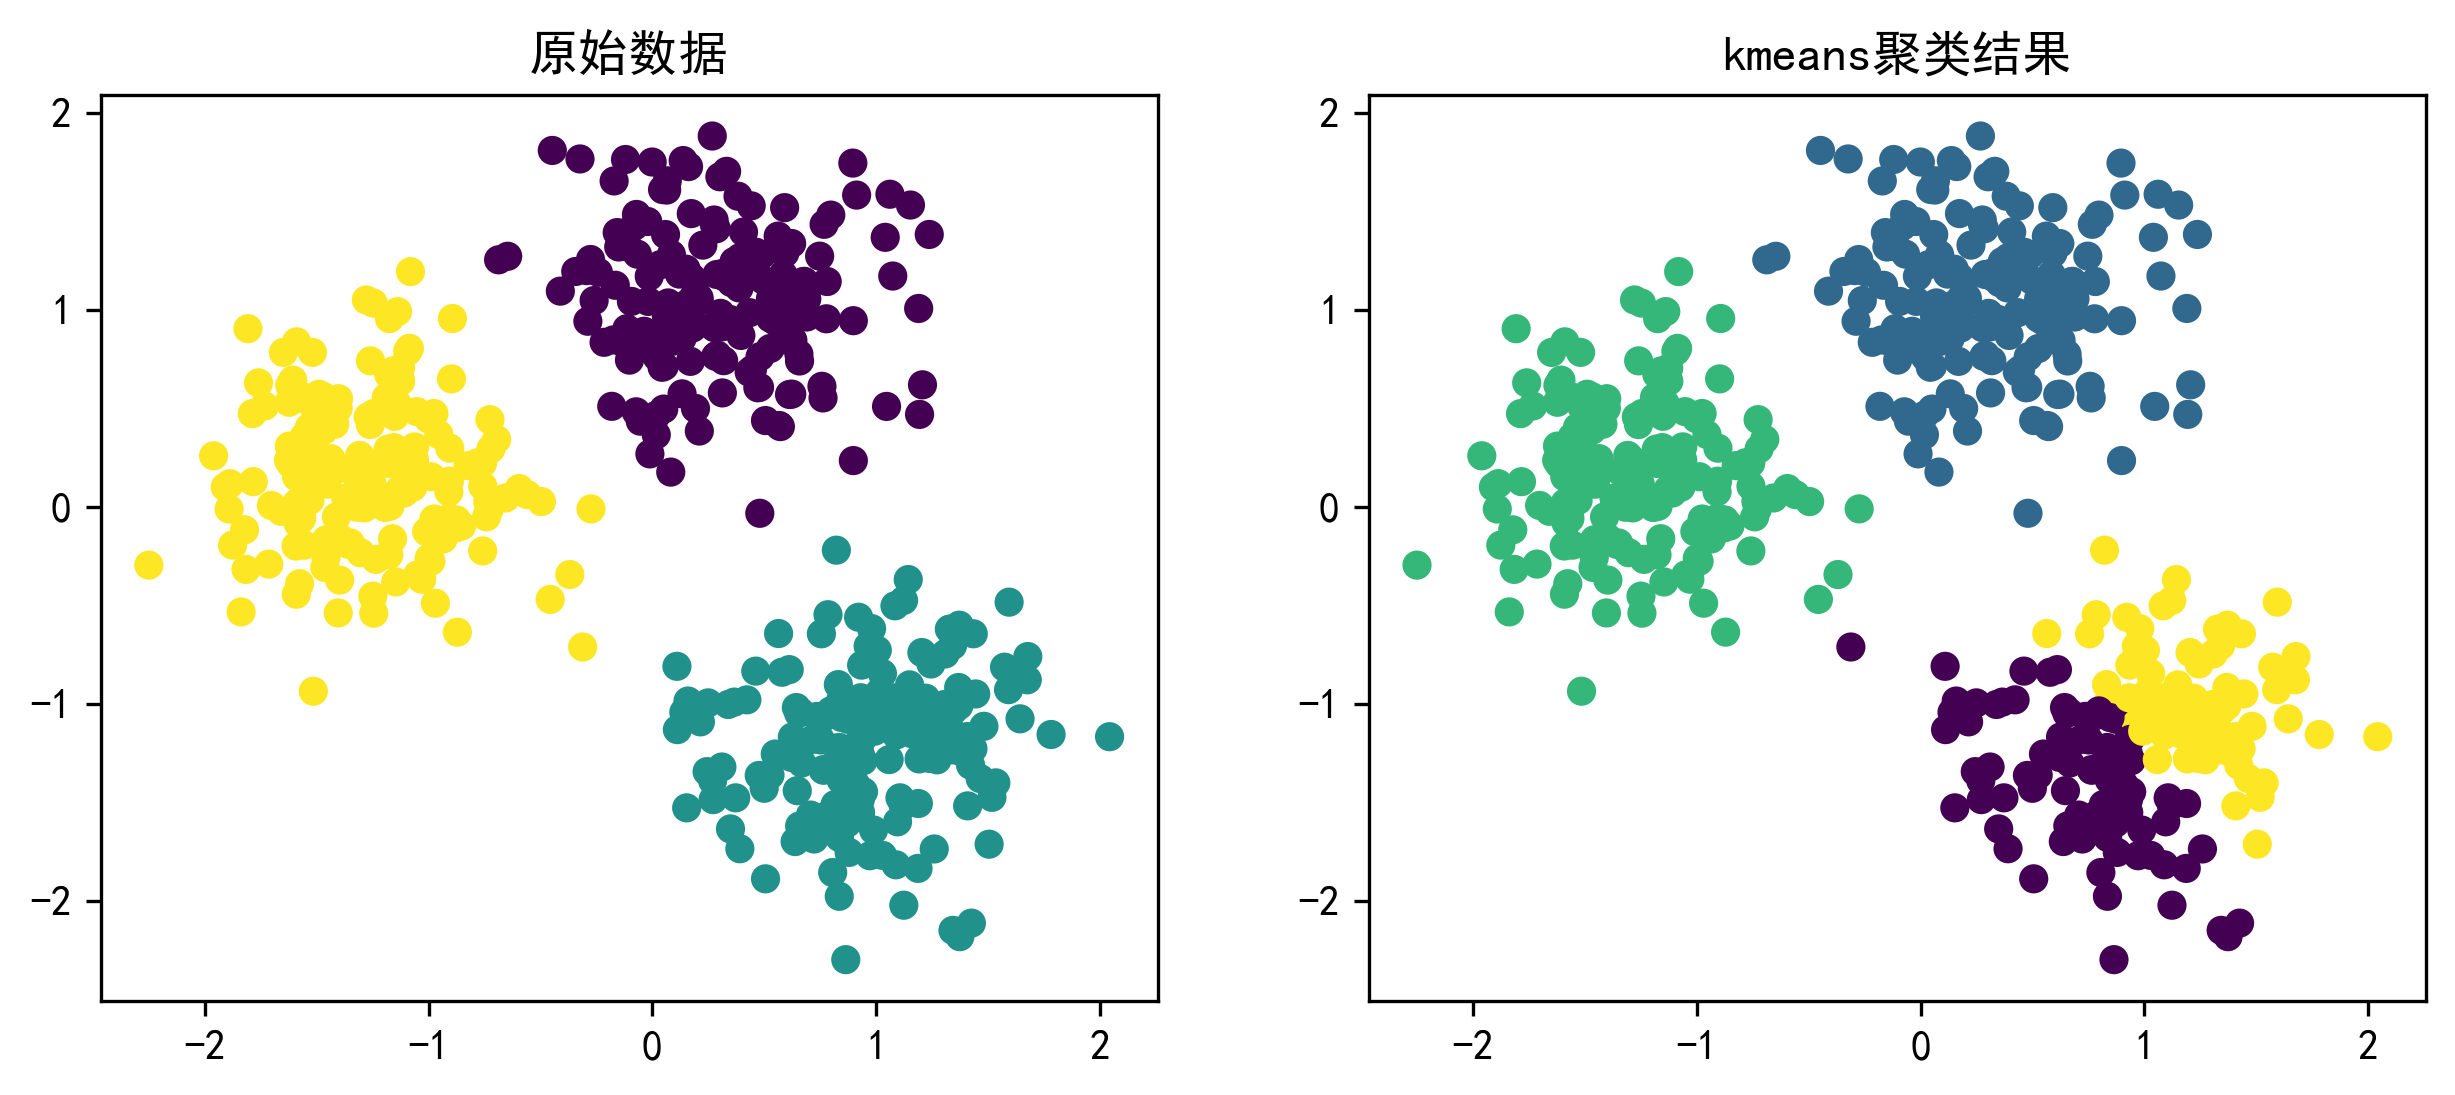

In [4]:
model_k2 = KMeans(n_clusters=2, random_state=0)
model_k3 = KMeans(n_clusters=3, random_state=0)
model_k4 = KMeans(n_clusters=4, random_state=0)
def plot_result(X, Y, model):
    # X,Y为原始数据及标签
    fig = plt.figure(1, (10, 4), dpi=300)
    ax1 = plt.subplot(121)
    # 绘制原始数据
    plt.scatter(X[:, 0], X[:, 1], c=Y)
    plt.title('原始数据')
    # 绘制聚类后的结果
    ax2 = plt.subplot(122)
    plt.scatter(X[:, 0], X[:, 1], c=model.fit(X).labels_)
    plt.title('kmeans聚类结果')
    plt.show()
plot_result(X, Y, model_k2)
plot_result(X, Y, model_k3)
plot_result(X, Y, model_k4)

## 轮廓图

In [5]:
model = [KMeans(n_clusters=i, random_state=0) for i in range(2, 5)]
train_model = [i.fit(X) for i in model]
silhouette_scores = [silhouette_score(X, i.labels_) for i in train_model]
silhouette_scores

[0.5687246211655754, 0.6590113982610379, 0.5385964313327916]

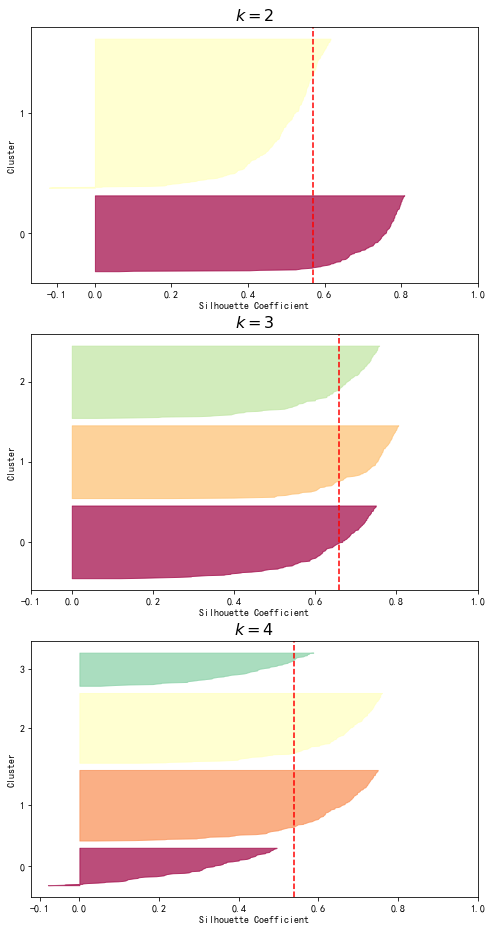

In [6]:
plt.figure(figsize=(8, 16))
for k in (2, 3, 4):
    plt.subplot(3, 1, k - 1)
    y_pred = train_model[k - 2].labels_
    # 默认采用欧式聚类
    silhouette_coefficients = silhouette_samples(X, y_pred, metric='euclidean')
    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()
        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding
    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (2, 3, 4):
        plt.xlabel("Silhouette Coefficient")
        plt.ylabel("Cluster")
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    else:
        plt.tick_params(labelbottom=False)
    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)
plt.show()

每个轮廓图包含一个刀形的聚类，高度表示集群包含的实例数，宽度表示集群中实例的排序轮廓系数（越宽越好）。虚线表
示平均轮廓系数。

垂直虚线表示每个集群的轮廓分数。当集群中的大多数实例的系数均低于此分数时（如果许多实例在虚线附近停止，在其左侧结束），则该集群比较糟糕，因为这意味着其实例太接近其他集群了。可以看到，当k=2或者k=4时，我们得到了不好的集群。但是当k=4或k=3时，集群看起来很好：大多数实例都超出虚线，向右延伸并接近1.0。

## 决策边界

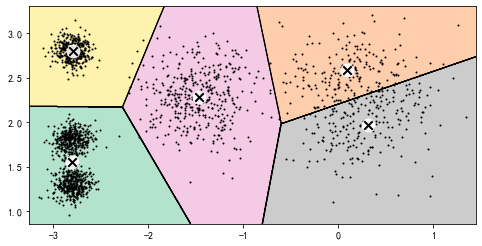

In [7]:
# 绘制类中心
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)
    
# 绘制决策边界
def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    plt.figure(figsize=(8, 4))
    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)
    plt.show()

blob_centers = np.array(
    [[ 0.2,  2.3],
     [-1.5 ,  2.3],
     [-2.8,  1.8],
     [-2.8,  2.8],
     [-2.8,  1.3]])
blob_std = np.array([0.4, 0.3, 0.1, 0.1, 0.1])
X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
model = KMeans(n_clusters=5, random_state=42)
model.fit(X)
plot_decision_boundaries(model, X)

<Figure size 720x576 with 0 Axes>

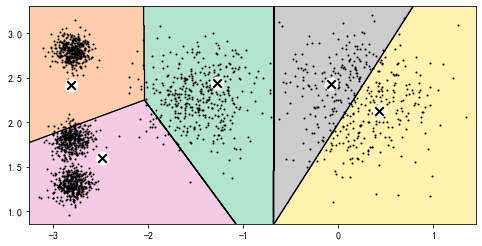

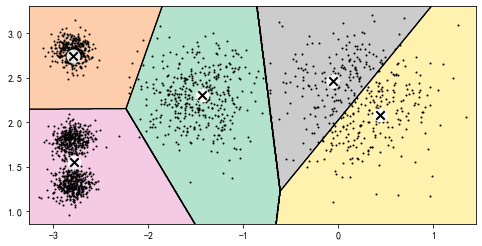

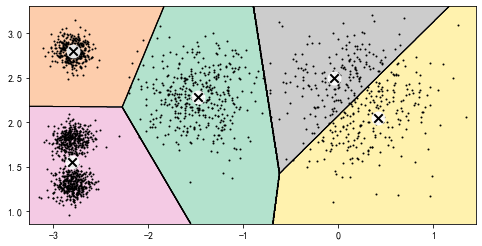

In [8]:
# 随机初始化类中心，看迭代1次2次3次的结果
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=0)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                    # 设置为full表示原始算法，否则使用加速算法
                     algorithm="full", max_iter=2, random_state=0)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=0)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

plt.figure(figsize=(10, 8))
plot_decision_boundaries(kmeans_iter1, X)
plot_decision_boundaries(kmeans_iter2, X)
plot_decision_boundaries(kmeans_iter3, X)

In [9]:
# transform（）方法可以测量每个实例到每个中心点的距离
model.transform(X)

array([[0.23085922, 3.04838567, 1.54568385, 1.45402521, 3.07528232],
       [0.26810747, 3.06126045, 1.48314418, 0.99002955, 3.19186267],
       [3.78216716, 1.66209651, 2.67172567, 4.09069201, 1.02742236],
       ...,
       [1.17785478, 2.89371096, 1.4073312 , 0.06769209, 3.20799557],
       [3.15905017, 0.23914671, 1.71339651, 3.05913478, 0.43887998],
       [0.43658314, 2.79657627, 1.21395695, 0.85434589, 2.95143035]])

K-Means也常用于降维，将数据集聚成几类就认为是降成几维。

# GMM

In [10]:
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_blobs
import numpy as np
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt

## 加载数据集

In [11]:
# centers代表类别数，传入元组是类别中心
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))
X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42)
X2 = X2 + [6, -8]
X = np.r_[X1, X2]
y = np.r_[y1, y2]

# n_components=3混合高斯模型个数，n_init=10运行多次选最优解，默认n_init=1
gm = GaussianMixture(n_components=3, n_init=10, random_state=42)
gm.fit(X)
print('每个高斯模型权重：', gm.weights_)
print('每个高斯模型均值：', gm.means_)
print('每个高斯模型权重方差：', gm.covariances_)
print('算法是否收敛：', gm.converged_)
# 对硬聚类使用predict（）方法，对软聚类使用predict_proba（）方法
# gm.predict(X)
# gm.predict_proba(X)

每个高斯模型权重： [0.40005972 0.20961444 0.39032584]
每个高斯模型均值： [[-1.40764129  1.42712848]
 [ 3.39947665  1.05931088]
 [ 0.05145113  0.07534576]]
每个高斯模型权重方差： [[[ 0.63478217  0.72970097]
  [ 0.72970097  1.16094925]]

 [[ 1.14740131 -0.03271106]
  [-0.03271106  0.95498333]]

 [[ 0.68825143  0.79617956]
  [ 0.79617956  1.21242183]]]
算法是否收敛： True


## 决策边界

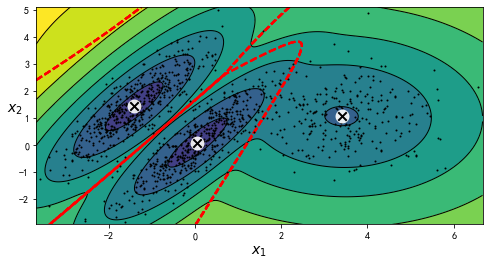

In [12]:
# 绘制类中心
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=35, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=2, linewidths=12,
                color=cross_color, zorder=11, alpha=1)

# 绘制模型的集群均值，决策边界（虚线），和密度等值线
def plot_gaussian_mixture(clusterer, X, resolution=1000, show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = -clusterer.score_samples(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z,
                 norm=LogNorm(vmin=1.0, vmax=30.0),
                 levels=np.logspace(0, 2, 12))
    plt.contour(xx, yy, Z,
                norm=LogNorm(vmin=1.0, vmax=30.0),
                levels=np.logspace(0, 2, 12),
                linewidths=1, colors='k')

    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z,
                linewidths=2, colors='r', linestyles='dashed')
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)
    plot_centroids(clusterer.means_, clusterer.weights_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.show()

## 集群形状的选择

当存在多个维度、多个集群或很少实例时，EM可能难以收敛到最佳解决方案。你可能需要通过限制算法必须学习的参数数量来降低任务的难度。一种方法是限制集群可能具有的形状和方向的范围，这可以通过对协方差矩阵施加约束来实现。为此，将covariance_type超参数设置为以下值之一：

"spherical"所有集群都必须是球形的，但它们可以具有不同的直径（即不同的方差）。

"diag"集群可以采用任何大小的任意椭圆形，但是椭圆形的轴必须平行于坐标轴（即协方差矩阵必须是对角线）。

"tied"所有集群必须具有相同的椭圆形状、大小和方向（即所有集群共享相同的协方差矩阵）。

默认情况下，covariance_type等于"full"，意味着每个集群可以采用任何形状、大小和方向（它具有自己无约束的协方差矩阵）。

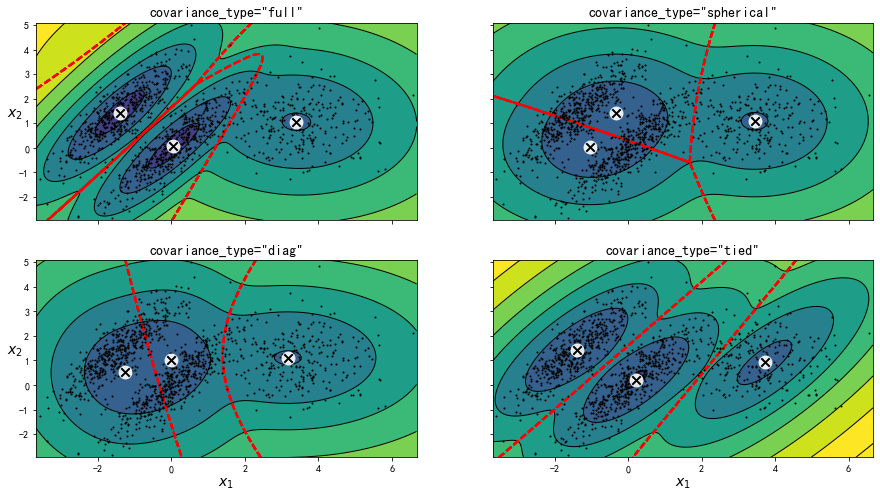

In [13]:
gm_full = GaussianMixture(n_components=3, n_init=10, covariance_type="full", random_state=42)
gm_tied = GaussianMixture(n_components=3, n_init=10, covariance_type="tied", random_state=42)
gm_spherical = GaussianMixture(n_components=3, n_init=10, covariance_type="spherical", random_state=42)
gm_diag = GaussianMixture(n_components=3, n_init=10, covariance_type="diag", random_state=42)
gm_full.fit(X)
gm_tied.fit(X)
gm_spherical.fit(X)
gm_diag.fit(X)

def compare_gaussian_mixtures(gm1, gm2, gm3, gm4, X):
    plt.figure(figsize=(15, 8))

    plt.subplot(221)
    plot_gaussian_mixture(gm1, X, show_xlabels=False)
    plt.title('covariance_type="{}"'.format(gm1.covariance_type), fontsize=14)
    
    plt.subplot(222)
    plot_gaussian_mixture(gm2, X, show_xlabels=False, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm2.covariance_type), fontsize=14)
    
    plt.subplot(223)
    plot_gaussian_mixture(gm3, X)
    plt.title('covariance_type="{}"'.format(gm3.covariance_type), fontsize=14)
    
    plt.subplot(224)
    plot_gaussian_mixture(gm4, X, show_ylabels=False)
    plt.title('covariance_type="{}"'.format(gm4.covariance_type), fontsize=14)
    plt.show()
    
compare_gaussian_mixtures(gm_full, gm_spherical, gm_diag, gm_tied, X)

## 异常检测

异常检测（也称为离群值检测）是检测严重偏离标准的实例的任务。这些实例称为异常或离群值，而正常实例称为内值。异常检测在各种应用中很有用，例如欺诈检测，在制造业中检测有缺陷的产品，或在训练一个模型之前从数据集中删除异常值（这可以显著提高所得模型的性能）。

使用高斯混合模型进行异常检测非常简单：位于低密度区域的任何实例都可以被视为异常。你必须定义要使用的密度阈值。例如，在试图检测缺陷产品的制造业公司中，缺陷产品的比例通常是已知的，假设它等于4%。将密度阈值设置为导致4%的实例位于该阈值密度以下的区域中的值。如果你发现误报过多（即标记为有缺陷的好产品），则可以降低阈值。相反，如果假负过多（即系统未将其标记为次品的次品），则可以提高阈值。

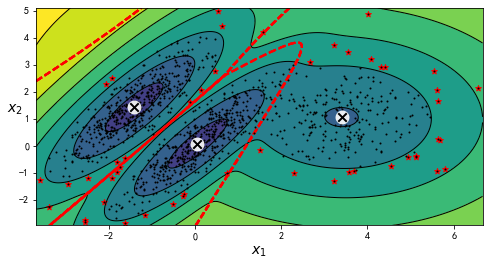

In [14]:
densities = gm.score_samples(X)
density_threshold = np.percentile(densities, 4)
anomalies = X[densities < density_threshold]

plt.figure(figsize=(8, 4))
plot_gaussian_mixture(gm, X)
plt.scatter(anomalies[:, 0], anomalies[:, 1], color='r', marker='*')
plt.ylim(top=5.1)
plt.show()

## 选择聚类数

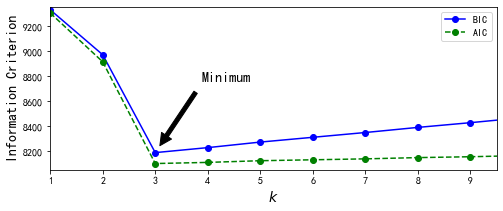

In [15]:
gms_per_k = [GaussianMixture(n_components=k, n_init=10, random_state=42).fit(X) for k in range(1, 11)]
bics = [model.bic(X) for model in gms_per_k]
aics = [model.aic(X) for model in gms_per_k]

plt.figure(figsize=(8, 3))
plt.plot(range(1, 11), bics, "bo-", label="BIC")
plt.plot(range(1, 11), aics, "go--", label="AIC")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Information Criterion", fontsize=14)
plt.axis([1, 9.5, np.min(aics) - 50, np.max(aics) + 50])
plt.annotate('Minimum',
             xy=(3, bics[2]),
             xytext=(0.35, 0.6),
             textcoords='figure fraction',
             fontsize=14,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.legend()
plt.show()

In [16]:
min_bic = np.infty

for k in range(1, 11):
    for covariance_type in ("full", "tied", "spherical", "diag"):
        bic = GaussianMixture(n_components=k, n_init=10,
                              covariance_type=covariance_type,
                              random_state=42).fit(X).bic(X)
        if bic < min_bic:
            min_bic = bic
            best_k = k
            best_covariance_type = covariance_type
print('聚类数和集群形状为：', best_k, best_covariance_type)

聚类数和集群形状为： 3 full


# DBSCAN

## 加载数据集

In [17]:
# 导入所需的库
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt

# 生成示例数据集
np.random.seed(0)
X = np.random.randn(300, 2)

# 训练DBSCAN模型
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan.fit(X)
# 索引为-1的是离群点
print('聚类为：', np.unique(dbscan.labels_))
# core_sample_indices_变量可以得到核心实例的索引
print('核心点的个数：', len(dbscan.core_sample_indices_))
# components_变量可以得到核心实例本身
print('核心点是：', dbscan.components_)

聚类为： [-1  0  1  2  3]
核心点的个数： 202
核心点是： [[ 1.76405235  0.40015721]
 [ 0.95008842 -0.15135721]
 [-0.10321885  0.4105985 ]
 [ 0.76103773  0.12167502]
 [ 0.44386323  0.33367433]
 [ 0.3130677  -0.85409574]
 [ 0.04575852 -0.18718385]
 [ 0.15494743  0.37816252]
 [-0.34791215  0.15634897]
 [-0.38732682 -0.30230275]
 [-1.04855297 -1.42001794]
 [-0.50965218 -0.4380743 ]
 [-1.25279536  0.77749036]
 [-0.51080514 -1.18063218]
 [-0.02818223  0.42833187]
 [ 0.06651722  0.3024719 ]
 [-0.63432209 -0.36274117]
 [-0.67246045 -0.35955316]
 [-0.81314628 -1.7262826 ]
 [-1.63019835  0.46278226]
 [-0.90729836  0.0519454 ]
 [ 0.72909056  0.12898291]
 [ 0.40234164 -0.68481009]
 [-0.87079715 -0.57884966]
 [-0.31155253  0.05616534]
 [-1.16514984  0.90082649]
 [ 0.46566244 -1.53624369]
 [ 1.17877957 -0.17992484]
 [-1.07075262  1.05445173]
 [ 0.3563664   0.70657317]
 [ 0.12691209  0.40198936]
 [-1.270485    0.96939671]
 [-0.41361898 -0.74745481]
 [ 0.94725197 -0.15501009]
 [ 0.61407937  0.92220667]
 [ 0.37642553 -

## 可视化核心点、边界点和噪声点

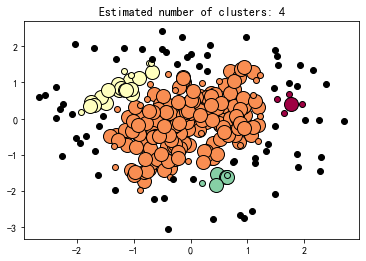

In [18]:
# 绘制聚类结果
labels = dbscan.labels_
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# 噪声点为-1，簇标记从0开始
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 噪声点为黑色
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title(f'Estimated number of clusters: {n_clusters}')
plt.show()

# AGNES

## 加载数据集

In [19]:
import numpy as np

np.random.seed(42)
X = np.random.randn(20, 2)

## 绘制层次聚类树

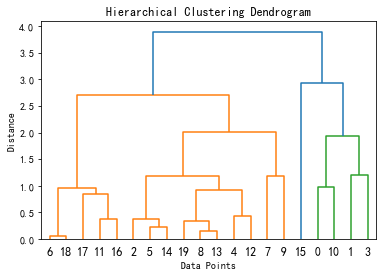

In [20]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# 步骤1: 计算距离矩阵
distances = linkage(X, method='complete', metric='euclidean')

# 步骤2-4: 生成层次聚类树
dendrogram(distances)

# 添加图标签和标题
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')

# 显示图形
plt.show()